In [8]:
import xarray as xr
import yaml
import numpy as np
import remap_tools  # local package to outsource the remap functions
import zarr_tools
import logging

from pathlib import Path
import easygems.healpix as egh
import uxarray as ux

In [9]:
import zarr
print(zarr.__version__)

2.18.4


In [10]:
logging.basicConfig()
logger = logging.getLogger("mpas2zarr")
logger.setLevel(logging.INFO)

In [11]:
infiles = {
    "3d": [],
    "2d": [
        "/glade/campaign/mmm/wmr/skamaroc/NSC_2023/3.75km_simulation_output_old_transport/DYAMOND_diag_1h.3.75km.2020-01-20_00.00.00.nc",
        "/glade/campaign/mmm/wmr/skamaroc/NSC_2023/3.75km_simulation_output_old_transport/DYAMOND_diag_1h.3.75km.2020-01-20_01.00.00.nc",
    ],
    "grid" : "/glade/derecho/scratch/clyne/x1.41943042.static.nc"  
}

In [12]:
def convert_files(zoom, subset, output_dir, config):
    files = infiles[subset]
    grid_file = infiles["grid"]
    outfile = Path(f"{output_dir}/MPAS_{subset}_z{zoom}.zarr")
    weights_file = Path(f"{output_dir}/MPAS_weights_{subset}_z{zoom}.nc")
    curr_conf = config[subset]
    timechunk = curr_conf["chunks"]["time"]

    if not files:
        return None, None

    #ds = xr.open_mfdataset(files, chunks=curr_conf["chunks"], use_cftime=True)
    ds = xr.open_mfdataset(files, chunks=curr_conf["chunks"], concat_dim="Time", combine="nested")
    ds_grid = xr.open_dataset(grid_file)
    if subset == "2d":
        out_ds = process_2d(curr_conf, ds, ds_grid)
    elif subset == "3d":
        out_ds = process_3d(curr_conf, ds, ds_grid)
    else:
        raise RuntimeError("Unknown subset type")

    weights = None
    if weights_file.exists():
        print("reading weights file ", weights_file)
        weights = xr.open_dataset(weights_file)
    else:
        print("generating weights file ", weights_file)
        weights = remap_tools.gen_weights(out_ds, zoom)
        weights.to_netcdf(weights_file)

    print("remap_delauny ", weights_file)
    out_ds = remap_tools.remap_delaunay(out_ds, zoom, weights=weights)
    
    logger.info(f"Trying to write to {outfile}")
    if not outfile.exists():
        zarr_tools.create_zarr_structure(
            path=outfile, outds=out_ds, timechunk=timechunk, order=zoom
        )
    zarr_tools.write_parts(outds=out_ds, path=outfile, time_chunk=24)
    return out_ds, outfile


def process_2d(curr_conf, ds, ds_grid):
    ds = ds.rename(curr_conf["renames"])
    ds_grid = ds_grid.rename({"nCells" : "ncells"})
    #ds = ds.isel(curr_conf["isel"])
    #ds = ds.drop_vars(list(curr_conf["isel"]) + curr_conf["drop"])
    ds = ds.drop_vars(curr_conf["drop"])
    if "nVertices" in ds.dims:
        ds = ds.drop_dims("nVertices")
    ds["lon"] = np.rad2deg(ds_grid["lonCell"])
    ds["lat"] = np.rad2deg(ds_grid["latCell"])
    return ds

def process_3d(curr_conf, ds, ds_grid):
    ds = ds.rename(curr_conf["renames"])
    ds_grid = ds_grid.rename({"nCells" : "ncells"})
    ds = ds.drop_vars(curr_conf["drop"])
    if "nVertices" in ds.dims:
        ds = ds.drop_dims("nVertices")
    ds["lon"] = np.rad2deg(ds_grid["lonCell"])
    ds["lat"] = np.rad2deg(ds_grid["latCell"])
    return ds

In [13]:
output_dir = "/glade/derecho/scratch/clyne"
config = yaml.safe_load(open("mpas_to_zarr.yaml"))

for subset in ("3d", "2d"):
    for zoom in (config[subset]['zoom_levels']):
        print("Processing zoom level ", zoom)
        out_ds, outfile = convert_files(
            zoom=zoom, subset=subset, output_dir=output_dir, config=config
        )

Processing zoom level  11
Processing zoom level  10
Processing zoom level  9
Processing zoom level  8
Processing zoom level  7
Processing zoom level  6
Processing zoom level  5
Processing zoom level  11
generating weights file  /glade/derecho/scratch/clyne/MPAS_weights_2d_z11.nc
remap_delauny  /glade/derecho/scratch/clyne/MPAS_weights_2d_z11.nc


INFO:mpas2zarr:Trying to write to /glade/derecho/scratch/clyne/MPAS_2d_z11.zarr
INFO:zarr_tools:Processed time steps starting at 0


Processing zoom level  10
generating weights file  /glade/derecho/scratch/clyne/MPAS_weights_2d_z10.nc
remap_delauny  /glade/derecho/scratch/clyne/MPAS_weights_2d_z10.nc


INFO:mpas2zarr:Trying to write to /glade/derecho/scratch/clyne/MPAS_2d_z10.zarr
INFO:zarr_tools:Processed time steps starting at 0


Processing zoom level  9
reading weights file  /glade/derecho/scratch/clyne/MPAS_weights_2d_z9.nc
remap_delauny  /glade/derecho/scratch/clyne/MPAS_weights_2d_z9.nc


INFO:mpas2zarr:Trying to write to /glade/derecho/scratch/clyne/MPAS_2d_z9.zarr
INFO:zarr_tools:Found status file. Starting from 24.


Processing zoom level  8
reading weights file  /glade/derecho/scratch/clyne/MPAS_weights_2d_z8.nc
remap_delauny  /glade/derecho/scratch/clyne/MPAS_weights_2d_z8.nc


INFO:mpas2zarr:Trying to write to /glade/derecho/scratch/clyne/MPAS_2d_z8.zarr
INFO:zarr_tools:Found status file. Starting from 24.


Processing zoom level  7


INFO:mpas2zarr:Trying to write to /glade/derecho/scratch/clyne/MPAS_2d_z7.zarr
INFO:zarr_tools:Found status file. Starting from 24.


reading weights file  /glade/derecho/scratch/clyne/MPAS_weights_2d_z7.nc
remap_delauny  /glade/derecho/scratch/clyne/MPAS_weights_2d_z7.nc
Processing zoom level  6


INFO:mpas2zarr:Trying to write to /glade/derecho/scratch/clyne/MPAS_2d_z6.zarr
INFO:zarr_tools:Found status file. Starting from 24.


reading weights file  /glade/derecho/scratch/clyne/MPAS_weights_2d_z6.nc
remap_delauny  /glade/derecho/scratch/clyne/MPAS_weights_2d_z6.nc
Processing zoom level  5


INFO:mpas2zarr:Trying to write to /glade/derecho/scratch/clyne/MPAS_2d_z5.zarr
INFO:zarr_tools:Found status file. Starting from 24.


reading weights file  /glade/derecho/scratch/clyne/MPAS_weights_2d_z5.nc
remap_delauny  /glade/derecho/scratch/clyne/MPAS_weights_2d_z5.nc


### 

In [14]:
filename = "/glade/derecho/scratch/clyne/MPAS_2d_z11.zarr"
ds = xr.open_dataset(filename, engine="zarr")
ds

<xarray.Dataset> Size: 12GB
Dimensions:         (time: 2, cell: 50331648)
Dimensions without coordinates: time, cell
Data variables: (12/31)
    hfx_tavg        (time, cell) float32 403MB ...
    initial_time    (time) |S64 128B ...
    lat             (cell) float32 201MB ...
    lh_tavg         (time, cell) float32 403MB ...
    lon             (cell) float32 201MB ...
    lwdnb           (time, cell) float32 403MB ...
    ...              ...
    swuptc          (time, cell) float32 403MB ...
    swuptc_tavg     (time, cell) float32 403MB ...
    tc_ice          (time, cell) float32 403MB ...
    tc_ice_tavg     (time, cell) float32 403MB ...
    tc_liquid       (time, cell) float32 403MB ...
    tc_liquid_tavg  (time, cell) float32 403MB ...
Attributes: (12/126)
    Conventions:                            MPAS
    camdim1:                                4
    config_IAU_option:                      off
    config_IAU_window_length_s:             21600.0
    config_apply_lbcs:                      NO
    config_apvm_upwinding:                  0.5
    ...                                     ...
    on_a_sphere:                            YES
    parent_id:                              tklnzdrcya\n2khx76imbh\n7ebd467f\n
    source:                                 MPAS
    sphere_radius:                          6371229.0
    x_period:                               0.0
    y_period:                               0.0

<Figure size 640x480 with 0 Axes>

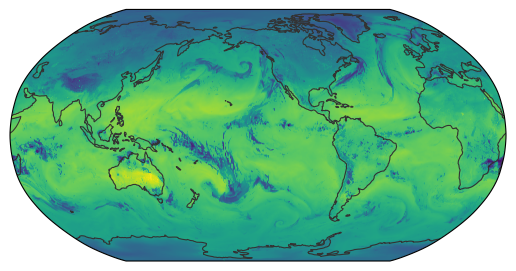

In [20]:
egh.healpix_show(ds.lwupt.isel(time=1))

In [15]:
uxds = ux.UxDataset.from_healpix(ds)

In [19]:
%%time
uxds.lwupt.isel(time=1).plot.points(rasterize=True, dynamic=True)

CPU times: user 696 ms, sys: 184 ms, total: 880 ms
Wall time: 1.58 s


:DynamicMap   []
   :Image   [lon,lat]   (lon_lat z)